## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Marov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numba import njit

plt.rcParams.update({
     "text.usetex": True,
     "font.family": "Helvetica"
}) 

In [2]:
# initialize a 2dim array where the axis 0 specifies the state
# in which you are and the axis 1 contains the transition probabilities
# (from the draw above) of jumping from the current state to the others. 
states = np.array([[0.90, 0.075, 0.025],        # Bull market 
                   [0.15, 0.8  , 0.05 ],        # Bear market 
                   [0.25, 0.25 , 0.5  ]])       # Stagnant market 

Nit = int(1e7)
init = random.randint(0, 2) # defines the initial random state. 

def MarketMC(Nit, init, states):
    current = init              # current state given by a random number 0, 1 or 2.
    bull, bear, stag = 0, 0, 0  # counters
    for i in range(Nit):
        x = random.random()
        if x <= states[current, 0]:
            current = 0 # Bull market
            bull += 1
        elif (1.0 - x) <= states[current, 1]:
            current = 1 # Bear market
            bear += 1
        else:
            current = 2 # Stagnant market
            stag += 1
    # print the fraction of number of times you were in the
    # 3 states during the 'Nit' executions. 
    print(bull / Nit, bear / Nit, stag / Nit)

In [3]:
%timeit MarketMC(Nit, init, states)

0.6244063 0.312994 0.0625997
0.6250037 0.3123827 0.0626136
0.6242354 0.3130617 0.0627029
0.6243804 0.3129219 0.0626977
0.6251586 0.3126196 0.0622218
0.6249986 0.3123539 0.0626475
0.6250452 0.3125606 0.0623942
0.6250555 0.3126387 0.0623058
1.41 s ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
m_MarketMC = njit(MarketMC)

In [5]:
%timeit m_MarketMC(Nit, init, states)

0.6249571 0.3126122 0.0624307
0.6242741 0.3131455 0.0625804
0.6254021 0.3121257 0.0624722
0.6249698 0.3125549 0.0624753
0.6252673 0.3123621 0.0623706
0.6249037 0.3127138 0.0623825
0.6254619 0.3119414 0.0625967
0.6249519 0.3125442 0.0625039
57.6 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Q3: Scaling

(This is about multiprocessing)

The ["scaling"](https://hpc-wiki.info/hpc/Scaling) of a code refers to its performance of as a function of the number of cores adopted. 

- Define a computationally intensive task (something like an operation on two giant arrays with >1e7 numbers or, even better!, pick somethinbg from your research). 
- Make sure it's embarassingly parallel. 
- Implement a parallelization strategy using multiprocessing. 
- Plot the time the code takes as a function of the number of cores.
- Figure out the number of cores in your CPU and make sure the plot extends both below and above this number.
- Interpret the resulting features. 
- A perfect scaling result in straight line (linear dependency). How perfect is your scaling?

### Important
Numpy has some inner, semi-automatic parallelization functionalities. Some, but not all, numpy functions detect the number of CPUs in your machine and make good use of them. That's great for most applications, but when performing a scaling study you want to control the parallelization yourself and disable what's done by numpy's. The following forces numpy to use a single core.  

In [6]:
import numpy as np
np.__config__.show()
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

openblas64__info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
blas_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
openblas64__lapack_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None), ('HAVE_LAPACKE', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None

In [7]:
import multiprocessing, pathos.multiprocessing
import os
import time

My work focuses on Lattice QCD simulations. Very often I have to analyze observables measurements extracted from suitable Markov Chains that implement the simulation algorithms. Typical observables are 2-pt correlation function, which are estimated using suitable improved estimators. Suppose to consider the measurments along the Markov Chain of an observable $q_i(t)$: the subcript specifies the so called $i$-th configuration along the chain, whereas the $t$-dependence encodes a physical time dependence of $q$. 

In the analaysis step it is often necessary to compute the following combination
$$
    c_i(t) \equiv \sum_{t'=0}^{T-1} q_i(t') q_i(t+t') \, ,
$$
where the sum $t+t'$ takes into account the periodic boundary conditions along the time direction of the lattice and we are assuming $t,t' = 0, \ldots, T-1$. Since both the total number of configurations and the temporal extent of the lattice could be very large, we are going to try to embarassingly parallelize previous computation. 

For simplicity and definiteness I will consider the case of T = 10000 dropping the configurations label, so only 1D arrays.

In [8]:
def my_fun(a,b):
    ''' 
        If a.size = b.size = T, the routine computes
            c(t) = sum_{t'=0}^{T-1} a(t') b(t+t')
        and returns sum_{t=0}^{T-1} c(t). 
    '''
    if not a.size == b.size:
        Exception("Input arrays must have the same shape.")
    c = np.zeros(a.size)
    for t in range(a.size):  
        c[t] = np.mean(a * np.roll(b, -t))
    return np.sum(c)

rep    = 10        # number of arrays to compute the CPUs times. 
ntimes = 30
T      = 10000
q1 = np.random.rand(rep, T)
q2 = np.random.rand(rep, T)

The following will take about 3 min and 30 secs.

In [9]:
times = []
for cpus in range(1, multiprocessing.cpu_count()*2+1):
    mp_map = pathos.multiprocessing.ProcessingPool(cpus).imap
    times.append(time.time())
    for _ in range(ntimes):
        res = list(  mp_map(my_fun, q1, q2)  )
    times[-1] = (time.time() - times[-1]) / ntimes

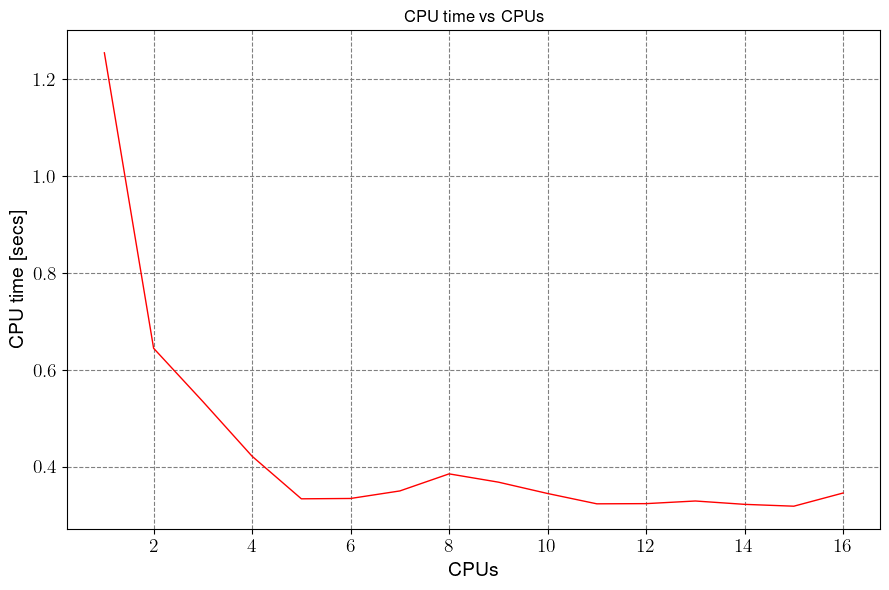

In [11]:
fig, ax = plt.subplots(figsize=(9,6))

fsize=14

ax.set_title(rf"CPU time vs CPUs")
ax.plot(np.arange(1,multiprocessing.cpu_count()*2+1), np.array(times), color='red', linestyle='-', linewidth='1.0', markersize=3.0)
ax.grid(color='grey', linestyle='--', axis='both')
ax.set_xlabel(rf"CPUs", fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.set_ylabel(rf"CPU time [secs]", fontsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
# plt.ylim([0, 2.0])
# plt.xlim([-0.1, 8.1])
fig.tight_layout()